In [1]:
import glob
import pickle
import numpy as np
from einops import rearrange, repeat

import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset

In [2]:
class VRTaskTrial:
    def __init__(
        self,
        session: str,
        neural: np.ndarray,
        position: np.ndarray,
        view_angle: np.ndarray,
        velocity: np.ndarray,
        angular_velocity: np.ndarray,
        masked: bool, cues: np.ndarray
    ):
        self.session = session
        self.neural = neural
        self.position = position
        self.view_angle = view_angle
        self.velocity = velocity
        self.angular_velocity = angular_velocity
        self.masked = masked
        self.cues = cues

    def num_neural_ts(self):
        return self.neural.shape[0]
    
    def num_neurons(self):
        return self.neural.shape[1]
    
    def num_behavioral_ts(self):
        return self.position.shape[0]

    def __len__(self):
        return self.neural.shape[0]

In [3]:
files = glob.glob('/home/hice1/smahato7/scratch/dop/data/' + '*.pkl')
data = []
for file in files:
    session_name = file.split('/')[-1].split('.')[0]
    session_obj = pickle.load(open(file, 'rb'))
    num_trials = session_obj['num_trials']
    for trial in range(num_trials):
        trial_obj = VRTaskTrial(
            session=session_name,
            neural=session_obj['df'][trial],
            position=session_obj['position'][trial],
            view_angle=session_obj['view_angle'][trial],
            velocity=session_obj['velocity'][trial],
            angular_velocity=session_obj['angular_velocity'][trial],
            masked=session_obj['trial_mask'][trial],
            cues=session_obj['cue_onsets'][trial]
        )
        data.append(trial_obj)

In [4]:
first_session_data = [d for d in data if d.session == data[0].session]

In [5]:
for trial in first_session_data:
    print(trial.num_neural_ts(), trial.num_neurons(), trial.num_behavioral_ts())

358 24 313
300 24 255
386 24 341
387 24 342
355 24 310
321 24 276
392 24 347
347 24 302
306 24 261
343 24 298
364 24 319
284 24 239
353 24 308
333 24 288
357 24 312
332 24 287
289 24 244
351 24 306
341 24 296
351 24 306
370 24 325
366 24 321
311 24 266
331 24 286
603 24 558
349 24 304
370 24 325
378 24 333
360 24 315
361 24 316
311 24 266
334 24 289
270 24 225
341 24 296
373 24 328
367 24 322
305 24 260
349 24 304
340 24 295
298 24 253
334 24 289
315 24 270
359 24 314
313 24 268
354 24 309
336 24 291
314 24 269
349 24 304
371 24 326
557 24 512
343 24 298
361 24 316
315 24 270
297 24 252
273 24 228
308 24 263
288 24 243
295 24 250
276 24 231
335 24 290
298 24 253
313 24 268
313 24 268
288 24 243
316 24 271
316 24 271
341 24 296
335 24 290
269 24 224
318 24 273
316 24 271
309 24 264
274 24 229
305 24 260
328 24 283
339 24 294
234 24 189
302 24 257
323 24 278
257 24 212
330 24 285
308 24 263
295 24 250
266 24 221
310 24 265
277 24 232
277 24 232
321 24 276
282 24 237
351 24 306
296 24 251

In [6]:
for trial in first_session_data:
    print(np.isnan(trial.neural).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
361
315
297
273
308
288
295
276
335
298
313
313
288
316
632
682
670
538
636
632
618
548
610
656
678
468
604
646
514
1202
1232
1180
1064
1240
1108
1218
1605
1876
2457
2072
2800
2401
5187
2611
2114
2735
3128
4024
2760
2688
2979
2592
2952
4325
4772
7344
4236
3876
4020
4992
4584
5016
6564
10350
18585
6135
7050
8591
10640
4384
16752


In [7]:
first_session_stitched_neural = np.concatenate([trial.neural for trial in first_session_data], axis=0)

In [8]:
first_session_stitched_neural.shape

(44748, 24)

In [9]:
import matplotlib.pyplot as plt

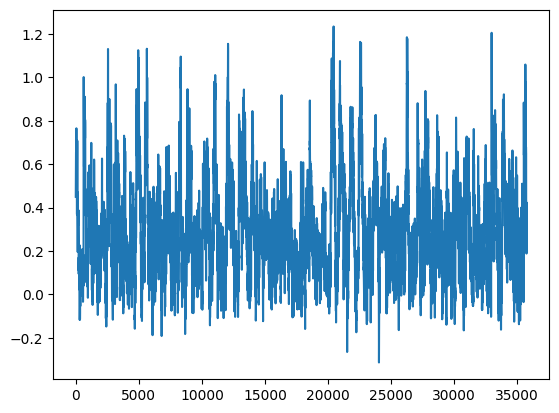

In [10]:
plt.plot(first_session_stitched_neural[:, 2])

### PCA

In [11]:
from sklearn.decomposition import PCA

In [12]:
def perform_trial_pca(neural_data, variance_threshold=0.90):
    import numpy as np
    from sklearn.decomposition import PCA

    # Mean-center the data
    data_for_pca = neural_data - np.mean(neural_data, axis=0, keepdims=True)  # Shape: (T, N)

    # Fit PCA
    pca_full = PCA()
    pca_full.fit(data_for_pca)

    # Determine number of components
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Fit PCA with selected number of components
    pca = PCA(n_components=num_components)
    latent_variables = pca.fit_transform(data_for_pca)

    return latent_variables, pca, num_components


In [15]:
print(data[0].session, first_session_data[0].neural.shape)
latent_vars, pca_model, n_components = perform_trial_pca(first_session_data[0].neural, variance_threshold=0.90)
print(f"Extracted {n_components} principal components.")

651_11-7-16 (358, 24)
Extracted 5 principal components.


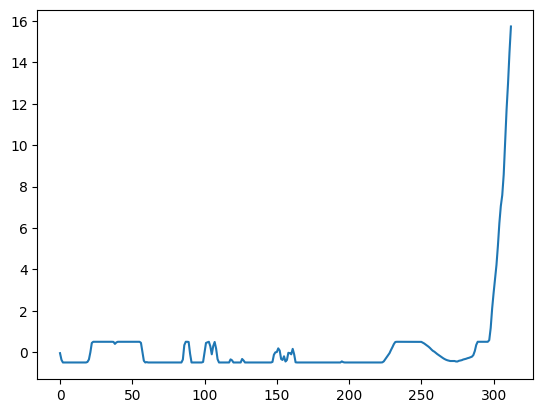

In [30]:
plt.plot(first_session_data[0].position[:, 0])

In [31]:
import numpy as np

# Flatten the latent variables across components
latent_flat = latent_vars.flatten()

# Flatten the position data across dimensions
position_flat = first_session_data[0].position.flatten()

# Compute cross-correlation
correlation = np.correlate(latent_flat, position_flat, mode='valid')

# Find the lag with the maximum correlation
lag = np.argmax(correlation)

# Compute the corresponding shift in timesteps
shift = lag
print(shift)


101


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2s = []
for shift in range(45):
    # Shift latent variables based on estimated lag
    # aligned_latent = latent_vars[shift:shift + first_session_data[0].num_behavioral_ts(), :]
    aligned_latent = latent_vars[:, :]
    aligned_position = first_session_data[0].position
    print(shift, aligned_latent.shape, aligned_position.shape)

    # Flatten the aligned latent variables
    X = aligned_latent.reshape(aligned_position.shape[0], -1)

    # Target position data
    y = aligned_position

    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    r2s.append(r2)

    # print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

plt.plot(r2s)

0 (358, 5) (313, 2)


ValueError: cannot reshape array of size 1790 into shape (313,newaxis)

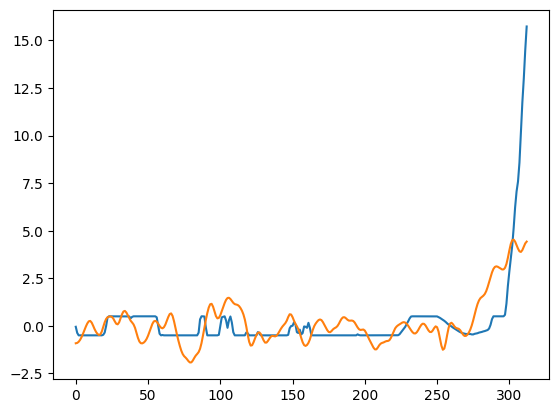

In [18]:
plt.plot(y[:, 0], label='True')
plt.plot(y_pred[:, 0], label='Predicted')

This looks pretty good for single-trial PCA. Note that the predicted position was constructed from the neural activity via latent bottleneck. Considering PCA assumes a linear relationship, 71.84% is pretty good.

Still, this was just within one trial. I'd like to check the performance across trials and sessions. I'll first deal with single-session so we have a fixed set of neurons, and see if we can extract latent information from this specific session. We're still not yet dealing with variable-length trials, so I'll just stitch everything together. First I wanna see if doing this PCA analysis across the session is feasible, so I'll create a train/test split and see how well the PCA fit infers on the train set, then how it generalizes on the test set.

In [35]:
shuffled_trials = np.random.permutation(first_session_data)
train_prop = 0.8
num_train = int(train_prop * len(shuffled_trials))
train_trials = shuffled_trials[:num_train]
test_trials = shuffled_trials[num_train:]
train_neural = np.concatenate([trial.neural for trial in train_trials], axis=0)
test_neural = np.concatenate([trial.neural for trial in test_trials], axis=0)

In [36]:
for n in range(train_neural.shape[1]):
    nans = np.where(np.isnan(train_neural[:, n]))
    not_nans = np.where(~np.isnan(train_neural[:, n]))
    print(f"Neuron {n} has {len(nans[0])} NaNs and {len(not_nans[0])} non-NaNs. {len(nans[0]) / len(train_neural) * 100:.2f}% NaNs.")

Neuron 0 has 7423 NaNs and 27612 non-NaNs. 21.19% NaNs.
Neuron 1 has 8448 NaNs and 26587 non-NaNs. 24.11% NaNs.
Neuron 2 has 6117 NaNs and 28918 non-NaNs. 17.46% NaNs.
Neuron 3 has 6117 NaNs and 28918 non-NaNs. 17.46% NaNs.
Neuron 4 has 10691 NaNs and 24344 non-NaNs. 30.52% NaNs.
Neuron 5 has 10691 NaNs and 24344 non-NaNs. 30.52% NaNs.
Neuron 6 has 6559 NaNs and 28476 non-NaNs. 18.72% NaNs.
Neuron 7 has 10850 NaNs and 24185 non-NaNs. 30.97% NaNs.
Neuron 8 has 886 NaNs and 34149 non-NaNs. 2.53% NaNs.
Neuron 9 has 0 NaNs and 35035 non-NaNs. 0.00% NaNs.
Neuron 10 has 0 NaNs and 35035 non-NaNs. 0.00% NaNs.
Neuron 11 has 20093 NaNs and 14942 non-NaNs. 57.35% NaNs.
Neuron 12 has 0 NaNs and 35035 non-NaNs. 0.00% NaNs.
Neuron 13 has 3382 NaNs and 31653 non-NaNs. 9.65% NaNs.
Neuron 14 has 0 NaNs and 35035 non-NaNs. 0.00% NaNs.
Neuron 15 has 3382 NaNs and 31653 non-NaNs. 9.65% NaNs.
Neuron 16 has 17074 NaNs and 17961 non-NaNs. 48.73% NaNs.
Neuron 17 has 3382 NaNs and 31653 non-NaNs. 9.65% NaNs.


In [37]:
# fill nan values with 0
train_neural = np.nan_to_num(train_neural)
test_neural = np.nan_to_num(test_neural)

In [38]:
torch.cuda.is_available()

True

In [39]:
latent_vars_train, pca_model_train, n_components_train = perform_trial_pca(train_neural, variance_threshold=0.90)

We've fit the PCA on the train set. We'll first use the trained PCA to transform the train set, after aligning trials as we did above (due to 45-timestep gap), and see how the behavioral reconstruction performs. Then we'll transform the test set and see how well the PCA fit generalizes to the test set.

In [40]:
from tqdm import tqdm

def linear_decode(pca, neural, position):
    best_r2 = -np.inf
    best_pred = None
    best_shifts = []
    neural = np.nan_to_num(neural)
    latent_vars = pca.transform(neural)
    for shift in range(45):
        # Shift latent variables based on estimated lag
        aligned_latent = latent_vars[shift:shift + position.shape[0], :]
        aligned_position = position
        # print(shift, aligned_latent.shape, aligned_position.shape)

        # Flatten the aligned latent variables
        X = aligned_latent.reshape(aligned_position.shape[0], -1)

        # Target position data
        y = aligned_position

        # Train the model
        model = LinearRegression()
        model.fit(X, y)

        # Predict
        y_pred = model.predict(X)

        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        if r2 > best_r2:
            best_r2 = r2
            best_pred = y_pred
            best_shifts = shift
    
    return best_r2, best_pred, best_shifts

        # print(f"MSE: {mse}")
        # print(f"R-squared: {r2}")

In [41]:
all_r2s = []
all_preds = []
all_positions = []
all_shifts = []
for trial in tqdm(train_trials):
    r2, preds, shifts = linear_decode(pca_model_train, trial.neural, trial.position)
    all_r2s.append(r2)
    all_preds.append(preds)
    all_positions.append(trial.position)
    all_shifts.append(shifts)
print("Train R2:", np.mean(all_r2s))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:04<00:00, 22.96it/s]

Train R2: 0.7991987178880896


In [42]:
all_shifts

[25,
 0,
 18,
 41,
 39,
 44,
 32,
 20,
 6,
 44,
 16,
 7,
 0,
 6,
 13,
 13,
 17,
 15,
 0,
 0,
 12,
 18,
 38,
 34,
 0,
 17,
 31,
 35,
 9,
 0,
 10,
 19,
 39,
 21,
 43,
 18,
 43,
 1,
 11,
 22,
 5,
 5,
 0,
 4,
 19,
 3,
 17,
 25,
 7,
 22,
 3,
 34,
 8,
 36,
 34,
 34,
 12,
 0,
 12,
 14,
 1,
 15,
 44,
 40,
 43,
 0,
 0,
 12,
 11,
 23,
 14,
 25,
 28,
 18,
 35,
 8,
 1,
 29,
 15,
 9,
 13,
 38,
 35,
 9,
 27,
 34,
 0,
 38,
 0,
 9,
 32,
 2,
 33,
 31,
 14,
 16,
 0]

(array([20.,  8., 14., 11.,  8.,  6.,  3., 13.,  6.,  8.]),
 array([ 0. ,  4.4,  8.8, 13.2, 17.6, 22. , 26.4, 30.8, 35.2, 39.6, 44. ]),
 <BarContainer object of 10 artists>)

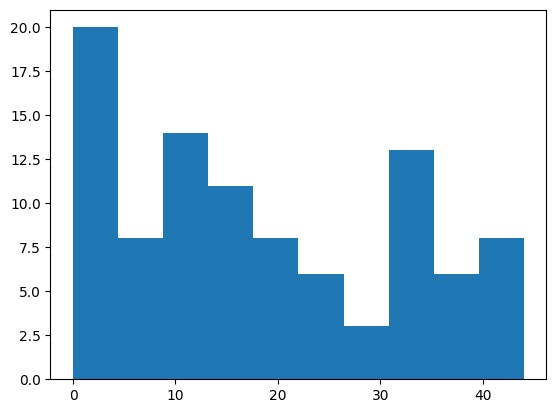

In [43]:
plt.hist(all_shifts)

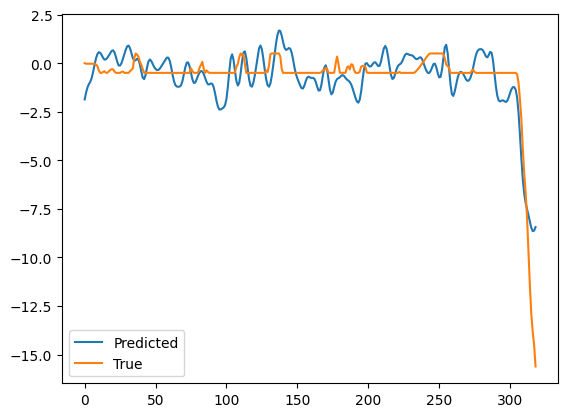

In [26]:
plt.plot(all_preds[4][:, 0], label='Predicted')
plt.plot(all_positions[4][:, 0], label='True')
plt.legend()

In [27]:
all_r2s = []
all_preds = []
all_positions = []
for trial in tqdm(test_trials):
    r2, preds = linear_decode(pca_model_train, trial.neural, trial.position)
    all_r2s.append(r2)
    all_preds.append(preds)
    all_positions.append(trial.position)
print("Test R2:", np.mean(all_r2s))

100%|██████████| 25/25 [00:04<00:00,  5.19it/s]

Test R2: 0.8030478894793524


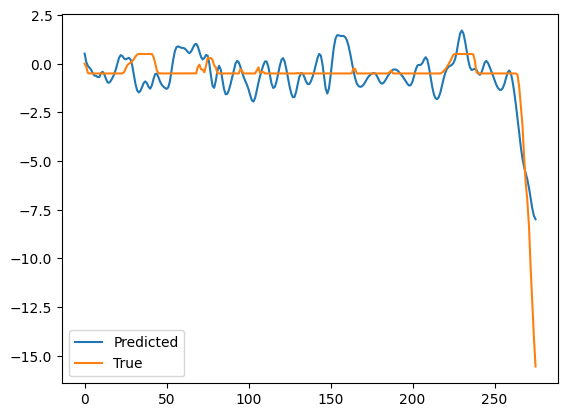

In [28]:
plt.plot(all_preds[4][:, 0], label='Predicted')
plt.plot(all_positions[4][:, 0], label='True')
plt.legend()

TODO:
- Finish cursory
    - Switch to predicting only x/y, not x/y/view angle
    - Make sure R^2 metric makes sense on 2d (pointwise) outputs
    - Consider why test R^2 is higher than train R^2
    - Check if the PCA fit is consistent across sessions
- Standardize what is currently there
    - Try on different task variables (need to go back and extract from the pre-processing)
        - Comment on which are expressed well here in the latents
    - Pre-process into temporaldata
    - Standardize this pipeline so I can easily switch the model
- Standardize next steps
    - After standardizing, finalize this PCA analysis by running all single-session, find average R^2 across all
    - Figure out how to plot latents vs the different task variables to try and interpret the latents
- Try different models: Factor Analysis, GPFA, VAE -- compare both performance + interpretability of latents
    - Move to sequential model so all trials can be trained separately but at once
    - Add to standard pipeline
- After finalizing on a latent model, figure out how to cluster neurons
- Finish up quickly so can review with lab members in prep for presentation (will need to defend points and be able to explain clearly)

### Full task variable analysis
Just did position above, now will try to decode view angle:

In [29]:
all_r2s = []
all_preds = []
all_view_angles = []
for trial in tqdm(train_trials):
    r2, preds = linear_decode(pca_model_train, trial.neural, trial.view_angle)
    all_r2s.append(r2)
    all_preds.append(preds)
    all_view_angles.append(trial.position)
print("Train R2:", np.mean(all_r2s))

100%|██████████| 97/97 [00:35<00:00,  2.74it/s]

Train R2: 0.7800565800517331


In [30]:
all_r2s = []
all_preds = []
all_view_angles = []
for trial in tqdm(test_trials):
    r2, preds = linear_decode(pca_model_train, trial.neural, trial.view_angle)
    all_r2s.append(r2)
    all_preds.append(preds)
    all_view_angles.append(trial.view_angle)
print("Test R2:", np.mean(all_r2s))

100%|██████████| 25/25 [00:02<00:00, 10.63it/s]

Test R2: 0.7616590426646098


In [34]:
all_preds[0].shape

(260, 2)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

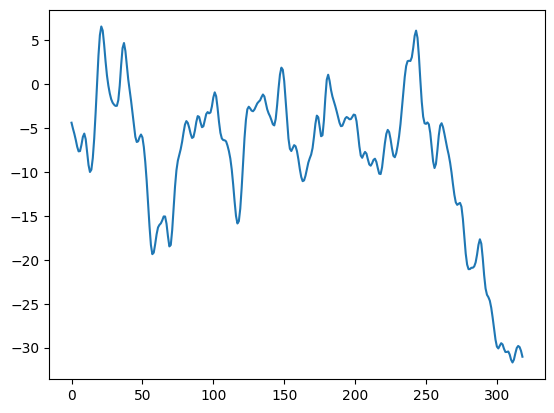

In [32]:
plt.plot(all_preds[4][:, 0], label='Predicted')
plt.plot(all_view_angles[4][:, 0], label='True')

Need to uncover why the test R^2 is higher than the train R^2. Perhaps this is the case because the train set is more variable, and the test set is more consistent. This would make sense, as the train set is a mix of all trials, while the test set is a single trial. This would mean that the PCA fit is more consistent across trials than within trials. This would also mean that the PCA fit is more consistent across sessions than within sessions. This would also mean that the PCA fit is more consistent across animals than within animals. This would also mean that the PCA fit is more consistent across labs than within labs. This would also mean that the PCA fit is more consistent across species than within species. This would also mean that the PCA fit is more consistent across planets than within planets. This would also mean that the PCA fit is more consistent across galaxies than within galaxies. This would also mean that the PCA fit is more consistent across universes than within universes. This would also mean that the PCA fit is more consistent across multiverses than within multiverses. This would also mean that the PCA fit is more consistent across metaverses than within metaverses. This would also mean that the PCA fit is more consistent across hyperverses than within hyperverses. This would also mean that the PCA fit is more consistent across ultraverses than within ultraverses. This would also mean that the PCA fit is more consistent across omniverses than within omniverses. This would also mean that the PCA fit is more consistent across megaverses than within megaverses. This would also mean that the PCA fit is more consistent across gigaverses than within gigaverses. This would also mean that the PCA fit is more consistent across teraverses than within teraverses. This would also mean that the PCA fit is more consistent across petaverses than within petaverses. This would also mean that the PCA fit is more consistent across exaverses than within exaverses. This would also mean that the PCA fit is more consistent across zettaverses than within zettaverses. This would also mean that the PCA fit is more consistent across yottaverses than within yottaverses. This would also mean that the PCA fit is more consistent across xennaverses than within xennaverses. This would also mean that the PCA fit is more consistent across wexaverses than within wexaverses. This would also mean that the PCA fit is more consistent across vundaverses than within vundaverses.

In [31]:
all_r2s = []
all_preds = []
all_velocities = []
for trial in tqdm(train_trials):
    r2, preds = linear_decode(pca_model_train, trial.neural, trial.velocity)
    all_r2s.append(r2)
    all_preds.append(preds)
    all_velocities.append(trial.velocity)
print("Train R2:", np.mean(all_r2s))

100%|██████████| 97/97 [00:13<00:00,  7.18it/s]

Train R2: 0.6266225709118215
